[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/185s49NcLNc-XnyJ8e5Oho9vgu89JMoou)





In [0]:
!pip install nose
!pip install matplotlib==3.0.3
#Runtime -> Restart 
#downgrade of matplotlib for seaborn heatmap, otherwise corners are cutted.

In [0]:
import pickle
from urllib.request import urlopen

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
np.random.RandomState(42)

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import time
import seaborn as sns

from nose.tools import *

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn import preprocessing
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier 
from xgboost.sklearn import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, 


# MNIST classification with machine learning algorithms



## Author: Hristo Mavrodiev
Project requirements - [link](https://www.dropbox.com/s/yd458ut3qbo3tr0/assessment-guidelines.txt?dl=1)


## Abstract:
The purpose of this research is to try a machine learning approach for classification on MNIST dataset. The research contains: Data exploration, feature scaling, dimensionality reduction, cross validation, tuning an algorithm. With KNeighborsClassifier is achived the higher accuracy.





## Introduction:
The MNIST is one of the classic datasets for classification. This dataset is widely used in many reseach and evaluated with many machine learning alorithms and neural networks. The used algorithms are LogisticRegression, XGBoost, SVM, K-neighborClassifier, RandomForest.

## The  Datasets description
 The data is gathered from build-in datasets in keras:  
 
"*The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field.*" [1]


## 1.Data loading and exploration


In [0]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step


In [0]:
x_train.shape

(60000, 28, 28)

In [0]:
y_train.shape

(60000,)

In [0]:
x_test.shape

(10000, 28, 28)

In [0]:
y_test.shape

(10000,)

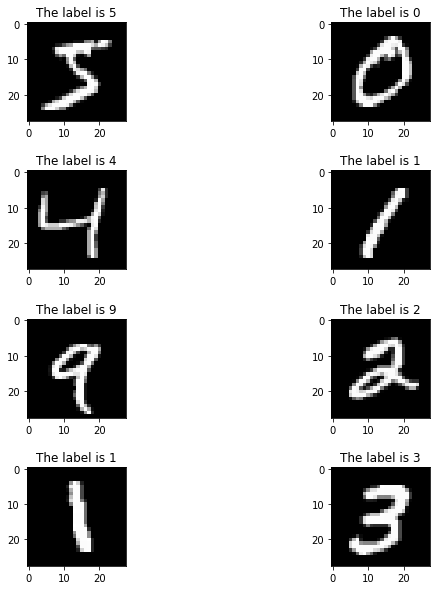

In [0]:
def plot_sample_mnist(n):
    """
    Function for plotting n samples of the dataset.
    Input:
    ---------
    n: number of samples
    
    Output:
    ---------
    plot with n samples
    
    """
    
    assert(n%2 ==0)
    
    fig = plt.figure(figsize=(10,10))
    fig.subplots_adjust(hspace=.5)
    for i in range(n):
        ax = fig.add_subplot(n/2,2,i+1)
        ax.imshow(x_train[i],  cmap='gray', interpolation='none')
        ax.set_title(f'The label is {y_train[i]}')
plot_sample_mnist(8)

In [0]:
x_train.shape

(60000, 28, 28)

Text(0.5, 0, 'label')

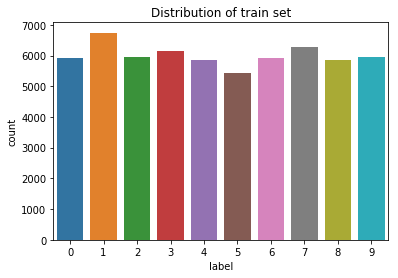

In [0]:
sns.countplot(y_train)
plt.title('Distribution of train set')
plt.xlabel('label')

Text(0.5, 0, 'label')

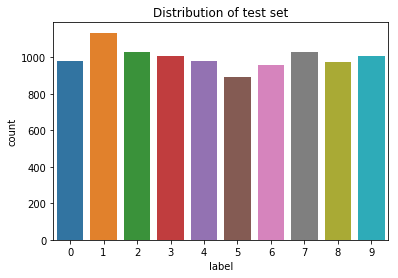

In [0]:
sns.countplot(y_test)
plt.title('Distribution of test set')
plt.xlabel('label')

The labels are shuffled and balanced, there is no need for oversampling.

## 2.Feature scaling and dimensionality reduction

The feature scaling is performed with devide by the max value 255, this will be enought to limit the values between 0 and 1.

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

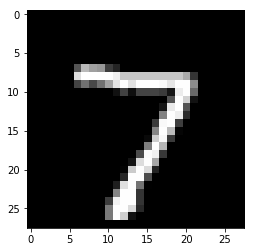

In [0]:
plt.imshow(x_test[0], cmap='gray', interpolation='none')

In [0]:
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

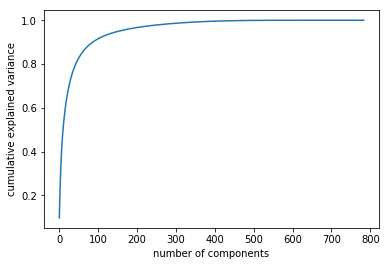

In [0]:
def pca_analysis(x_train):
    """
    Function to plot the cumulative explained variance in the data based of n_components.
    
    """

    pca = PCA().fit(x_train)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
pca_analysis(x_train)


In [0]:
pca = PCA(n_components=25)
x_train_tr = pca.fit_transform(x_train)
x_test_tr = pca.transform(x_test)
print(f'Explained variance after PCA is {sum(pca.explained_variance_ratio_)*100:.1f} %')

Explained variance after PCA is 69.2 %


The dimensions of the data are reduced, this will speed up the  training time of the algorithms. Another option is to reduce the number of observations(rows). The explained variance is reduced to 70%, should be good enough for correct predictions. The datasourse are pictures, so the reduction is not so much. This step is affecting the final score.

## 3.Machine Learning

## 3.1 Choosing an algorithm

In [0]:
def test_algorithms():
    
    """
    Function to compare several algorithms on train set.
    """
    
    classifiers = [
        LogisticRegression(),
        RandomForestClassifier(random_state=42),
        LinearSVC(random_state=42),
        SVC(),
        KNeighborsClassifier(),
        XGBClassifier(n_estimators = 30, random_state=42),
         
        ]
    
    cls_columns=['algorithm','score_rmsle_mean','score_std','time']
    cls_performance = pd.DataFrame(columns=cls_columns)
    print('Please wait for all algorithms to complete training.')
    for classifier in (classifiers):
        time_start = time.time()
        cv_results = cross_val_score(classifier, x_train_tr,y_train)
        time_end = round(time.time() - time_start,3)
        mean_score = round(cv_results.mean(),4)
        std_score = round(cv_results.std(),4)
        temp= pd.DataFrame([[classifier.__class__.__name__,mean_score,std_score,time_end]],columns = cls_columns)
        cls_performance = cls_performance.append(temp, ignore_index=True)
        print(classifier.__class__.__name__ , ' Score = ',mean_score , 'with std=',std_score ," execution_time =  ", time_end,"s")
    return cls_performance
#NOT EXECUTED TO SAVE 5 minutes
#cls_performance = test_algorithms()
#cls_performance.to_csv('Crossval.csv')
cls_performance = pd.read_csv('https://www.dropbox.com/s/ju02su0g7ha2l31/Crossval.csv?dl=1',index_col='Unnamed: 0')
cls_performance

,algorithm,score_rmsle_mean,score_std,time
0,LogisticRegression,0.8703,0.0037,21.009
1,RandomForestClassifier,0.9208,0.0034,8.759
2,LinearSVC,0.8678,0.0045,67.573
3,SVC,0.9775,0.0013,86.868
4,KNeighborsClassifier,0.9703,0.0009,59.591
5,XGBClassifier,0.8294,0.0030,64.003


The algorithms with top performance are SVC and KNeighborsClassifier. The SVC is more accurate, but KNC is more stable(less deviation) and faster (~25sec). As a top algorithm is choosen the KNeighborsClassfier to be tuned up.

## 3.2 KNeighborsClassifier tuning

In [0]:
def export_model(model):
    """
    Export sklearn trained model to a file.
    Input:model:sklearn trained model
    """
    pickle.dump(model, open(model.__class__.__name__ + '.model', 'wb'))
    print('Model saved as ' + model.__class__.__name__ + '.model')

In [0]:
def load_pickle(url):
    """
    Load existing trained model from pickle.
    Inputs:
    -------
    - url: url of the algorithm that will be downloaded
    
    Output:
    -------
    - sklearn trained model
    
    """
    try:
        loaded_model = pickle.load(urlopen(url))
        print('Model loaded.')
        return loaded_model
    except:
        print('Unable to load the model from url.')
        return 0

In [0]:
#Long running cell commented to save time
#grid_values = {'n_neighbors': [3,5,7,9]}
#grid_knn = GridSearchCV(KNeighborsClassifier(), n_jobs=-1, param_grid = grid_values, cv=3, scoring ='accuracy')
#grid_knn.fit(x_train_tr, y_train)
#export_model(grid_knn.best_estimator_)
#pd.DataFrame(grid_knn.cv_results_).to_csv('KNN_cv_results.csv')

In [0]:
#grid_knn.best_estimator_

In [0]:
tuned_knn = load_pickle('https://www.dropbox.com/s/qrams1ronigiru4/KNeighborsClassifier.model?dl=1')

Model loaded.


In [0]:
cv_results = pd.read_csv('https://www.dropbox.com/s/gmm51xfvm2jwg67/KNN_cv_results.csv?dl=1')
cv_results

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0,0.111226,0.013267,35.005893,1.560943,3,{'n_neighbors': 3},0.972456,0.969798,0.969295,0.970517,0.001386,1
1,1,0.099643,0.003002,38.095394,0.731080,5,{'n_neighbors': 5},0.971406,0.969298,0.970146,0.970283,0.000866,2
2,2,0.100786,0.003916,41.877446,0.622966,7,{'n_neighbors': 7},0.970406,0.968998,0.969245,0.969550,0.000614,3
3,3,0.101647,0.001528,43.528261,2.394375,9,{'n_neighbors': 9},0.968956,0.967598,0.967845,0.968133,0.000591,4


The algorithm with 5 neighbors is on second place, with lower std score. The algorithm with 3 neighbors is faster and with better accuracy - 0.9705.

In [0]:
train_score = accuracy_score(y_train, tuned_knn.predict(x_train_tr))
print(f'The score on training set is {train_score:.4f}')

The score on training set is 0.9876


## 3.3.Scoring on the testing set.

In [0]:
y_pred_test = tuned_knn.predict(x_test_tr)
test_score = accuracy_score(y_test, y_pred_test)
print(f'The score on training set is {test_score:.4f}')

The score on training set is 0.9729


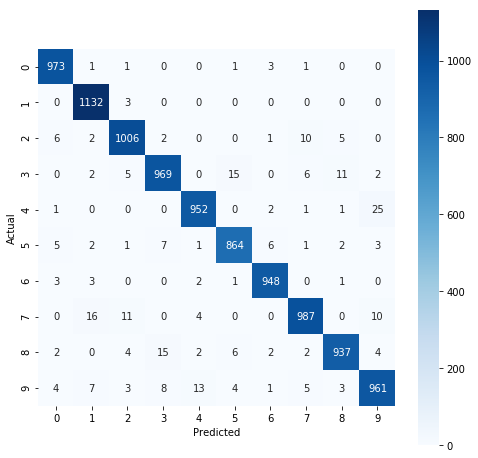

In [0]:
def plot_confusion_matrix(y_test, y_pred):
    """
    Function to plot confusion matrix between true values and predictions.
    Input:
    -----------
    y_test - true values
    y_pred - predicted values by a classification algorithm
    
    Output:
    ----------
    Seaborn plot
    """
    
    assert(y_test.shape == y_pred.shape)
    
    data = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(data,square = True, cmap = 'Blues', annot=True, fmt="0" )
    plt.xlabel('Predicted')
    plt.ylabel('Actual')


plot_confusion_matrix(y_test, y_pred_test)

In [0]:
target_score = 0.9950
print(f'Target score {target_score:.4f}')
print(f'Training score {train_score:.4f}')
print(f'Test score {test_score:.4f}')
print(f'Bias = {target_score - train_score:.4f}')
print(f'Variance = {train_score - test_score:.4f}')

Target score 0.9950
Training score 0.9876
Test score 0.9729
Bias = 0.0074
Variance = 0.0147


With the KNeighborClassifier was achieved the top accuracy of classifications. If we accept that the maximum accuracy that could be achieved = 99.5%, because of the dimensionaly reduction and there could be misslabeled features. There is a 0.7% bias and 1.47% variance.


## **Conclusion**:  
The result from the algorithm are very good, they have very high accuracy. This score could be compared in the official MNIST website[1]. The percent variance is 2x more than the bias in the tuned K-NeighborsClassifier. The next step could be adding more regularization as increasing the 'n_neighbors' value. This step should reduce the variance. On the step with dimensinality reduction was accepted to keep 69.2% of the data. This step is highly related with the final score of the algorithm. In the next steps of improving of the accuracy is to try with different values on PCA. Another things to try are neural networks combined with data augmentation techniques, image filters as bluring, rotating on small angle. 


## References:  
[1] MNIST dataset - http://yann.lecun.com/exdb/mnist/  
[2] PCA analysis - https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html  
[3] confusion_matrix - https://scikit-learn.org/0.17/auto_examples/model_selection/plot_confusion_matrix.html#example-model-selection-plot-confusion-matrix-py  
[4] https://hackernoon.com/idiots-guide-to-precision-recall-and-confusion-matrix-b32d36463556  